# Hypothesis 

The frequency of interdisciplinary terms from domains such as biology, physics, and neuroscience in titles has increased from 2018 to 2024 in ICLR, NeurIPS, and ICML, indicating growing cross-domain influence in ML research.

In [57]:
import pandas as pd 
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
from collections import defaultdict
import os 

import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
icml_iclr_neurips = pd.read_csv("../papers.csv")
icml_iclr_neurips = icml_iclr_neurips[icml_iclr_neurips['Year'] >= 2018]
icml_iclr_neurips

,Conference,Year,Title,Author,Affiliation
15308,ICLR,2018,Deep Complex Networks,Chiheb Trabelsi,Montreal Institute for Learning Algorithms / P...
15309,ICLR,2018,Deep Complex Networks,Olexa Bilaniuk,Université de Montréal
15310,ICLR,2018,Deep Complex Networks,Ying Zhang,Element AI
15311,ICLR,2018,Deep Complex Networks,Dmitriy Serdyuk,"MILA, University of Montreal"
15312,ICLR,2018,Deep Complex Networks,Sandeep Subramanian,"Mila, Universite de Montreal"
...,...,...,...,...,...
172159,NeurIPS,2024,Bayesian-guided Label Mapping for Visual Repro...,Chengyi Cai,University of Melbourne
172160,NeurIPS,2024,Bayesian-guided Label Mapping for Visual Repro...,Zesheng Ye,University of Melbourne
172161,NeurIPS,2024,Bayesian-guided Label Mapping for Visual Repro...,Lei Feng,Singapore University of Technology and Design
172162,NeurIPS,2024,Bayesian-guided Label Mapping for Visual Repro...,Jianzhong Qi,The University of Melbourne


# Domain selection and defining words 

For the sake of simplicity, we pick biology, neuroscience and physics 

In [59]:
bio_seeds = {
    # Molecular biology
    "genome", "protein", "dna", "rna", "enzyme", "chromosome", "nucleotide", "ribosome", 
    "mitochondria", "cytoplasm", "plasmid", "bacteria", "virus", "antibody", "antigen",
    
    # Evolution and genetics
    "evolution", "mutation", "phenotype", "genotype", "heredity", "phylogeny", "taxonomy",
    "lineage", "biodiversity", "speciation", "fossil", "adaptation", "extinction", "taxonomy",
    
    # Cell biology
    "cell", "membrane", "organelle", "nucleus", "golgi", "endoplasmic", "lysosome", "flagella",
    "chloroplast", "cytoskeleton", "endocytosis", "exocytosis", "apoptosis", "autophagy", 
    
    # Physiology
    "metabolism", "respiration", "photosynthesis", "digestion", "cardiovascular", "excretion", 
    "endocrine", "hormone", "homeostasis", "osmoregulation", "epithelial", "connective", 
    
    # Ecology
    "ecosystem", "biome", "habitat", "trophic", "symbiosis", "predation", "pollination", 
    "niche", "invasive", "biomass", "decomposer", "phytoplankton", "zooplankton", "herbivore"
}

In [60]:
physics_seeds = {
    # Classical mechanics
    "motion", "kinematics", "acceleration",  "inertia", "friction", "oscillation",
    "pendulum", "elasticity", "torque", "centripetal", "equilibrium", "projectile", "statics",
    
    # Electromagnetism
    "electromagnetic", "capacitance", "voltage", "current", "resistor", "inductor", "dielectric",
    "polarization", "permittivity", "ferromagnetism", "diamagnetism", "solenoid", "maxwell",
    
    # Thermodynamics
    "thermodynamics", "enthalpy", "isothermal", "adiabatic", "carnot", "boltzmann",
    "kelvin", "joule", "calorimetry", "conduction", "convection", "radiation", "irreversibility",
    
    # Modern physics
    "quantum", "relativity", "particle", "photon", "quark", "boson", "fermion", "radioactivity",
    "isotope", "superconductivity", "nuclear", "fission", "fusion", "hadron", "lepton",
    
    # Astrophysics
    "galaxy", "supernova", "nebula", "redshift", "pulsar", "quasar", "cosmology", "planetesimal",
    "asteroid", "parallax", "interferometry", "spectroscopy", "parsec", "ecliptic", "perihelion"
}
#"momentum","entropy", 

In [61]:
neuro_seeds = {
    # Neuroanatomy
    "cortex", "synapse", "cerebellum", "thalamus", "hypothalamus", "brainstem", 
    "ganglia", "dendrite", "myelin", "schwann", "astrocyte", "oligodendrocyte", "microglia",
    
    # Neurophysiology
    "action-potential", "depolarization", "repolarization", "neurotransmitter", "serotonin",
    "dopamine", "acetylcholine", "glutamate", "gaba", "receptor", "ion-channel", "vesicle",
    
    # Cognitive neuroscience
    "cognition", "perception",  "emotion",  "consciousness",
    "executive-function", "sensory", "psychophysics", "lateralization", "interoception",
    
    # Methods and techniques
    "fmri", "eeg", "meg", "pet-scan", "optogenetics", "electrophysiology", "stereotaxic",
    "histology", "tractography", "patch-clamp", "voltage-clamp", "immunohistochemistry",
    
    # Clinical neuroscience
    "neuropathy", "encephalopathy", "aphasia", "epilepsy", "parkinson", "alzheimer", 
    "cerebrospinal", "neuroendocrine", "neurodegeneration", "neuroprotection", "neurogenesis"
}
#"language","neuron", "attention", "memory",

### Key point: Domain-Overlapping Terms with ML/Data Science

#### Biology Overlaps
- Network, tree, model, population, selection, classification
- Evolution, adaptation, fitness, mutation, pathway, signal
- Clustering, diversity, assembly, structure, regulation

#### Physics Overlaps
- Vector, field, matrix, energy, state, phase, momentum
- Gradient, entropy, noise, force, decay, symmetry
- Dimension, transformation, oscillation, stability, coupling

#### Neuroscience Overlaps
- Neural network, learning, weight, plasticity, activation
- Feature, memory, attention, spike, encoding, bias
- Inhibition, connectivity, reinforcement, representation, threshold

#### Cross-Domain General
- Function, distribution, probability, parameter, normalization
- Optimization, dynamics, convergence, sampling, embedding
- Projection, boundary, complexity, generalization, scaling

In [ ]:
unique_titles_df = icml_iclr_neurips.drop_duplicates(subset="Title").copy()

def tokenize_title(title):
    return set(re.findall(r'\b[a-z]+\b', title.lower()))

freq_by_year = defaultdict(lambda: {"bio": 0, "physics": 0, "neuro": 0, "total": 0})

for _, row in unique_titles_df.iterrows():
    year = row['Year']
    tokens = tokenize_title(row['Title'])

    bio_hit = bool(tokens & bio_seeds)
    physics_hit = bool(tokens & physics_seeds)
    neuro_hit = bool(tokens & neuro_seeds)

    freq_by_year[year]["bio"] += int(bio_hit)
    freq_by_year[year]["physics"] += int(physics_hit)
    freq_by_year[year]["neuro"] += int(neuro_hit)
    freq_by_year[year]["total"] += 1  

interdisciplinary_df = pd.DataFrame.from_dict(freq_by_year, orient="index").sort_index()
interdisciplinary_df["bio_ratio"] = interdisciplinary_df["bio"] / interdisciplinary_df["total"]
interdisciplinary_df["physics_ratio"] = interdisciplinary_df["physics"] / interdisciplinary_df["total"]
interdisciplinary_df["neuro_ratio"] = interdisciplinary_df["neuro"] / interdisciplinary_df["total"]
interdisciplinary_df.reset_index(inplace=True)
interdisciplinary_df.rename(columns={"index": "Year"}, inplace=True)

interdisciplinary_df

,Year,bio,physics,neuro,total,bio_ratio,physics_ratio,neuro_ratio
0,2018,30,25,3,1966,0.015259,0.012716,0.001526
1,2019,34,38,13,2701,0.012588,0.014069,0.004813
2,2020,33,38,14,2982,0.011066,0.012743,0.004695
3,2021,63,64,24,4377,0.014393,0.014622,0.005483
4,2022,100,83,17,5229,0.019124,0.015873,0.003251
5,2023,168,134,45,7033,0.023887,0.019053,0.006398
6,2024,248,206,60,9466,0.026199,0.021762,0.006338


In [ ]:
folder_name = "titles_by_category"
os.makedirs(folder_name, exist_ok=True)

bio_titles = []
physics_titles = []
neuro_titles = []

for _, row in unique_titles_df.iterrows():
    year = row['Year']
    title = row['Title']
    tokens = tokenize_title(title)

    if tokens & bio_seeds:
        bio_titles.append((title, year))
    if tokens & physics_seeds:
        physics_titles.append((title, year))
    if tokens & neuro_seeds:
        neuro_titles.append((title, year))

bio_df = pd.DataFrame(bio_titles, columns=["Title", "Year"])
physics_df = pd.DataFrame(physics_titles, columns=["Title", "Year"])
neuro_df = pd.DataFrame(neuro_titles, columns=["Title", "Year"])

bio_df.to_csv(os.path.join(folder_name, "bio_titles.csv"), index=False)
physics_df.to_csv(os.path.join(folder_name, "physics_titles.csv"), index=False)
neuro_df.to_csv(os.path.join(folder_name, "neuro_titles.csv"), index=False)

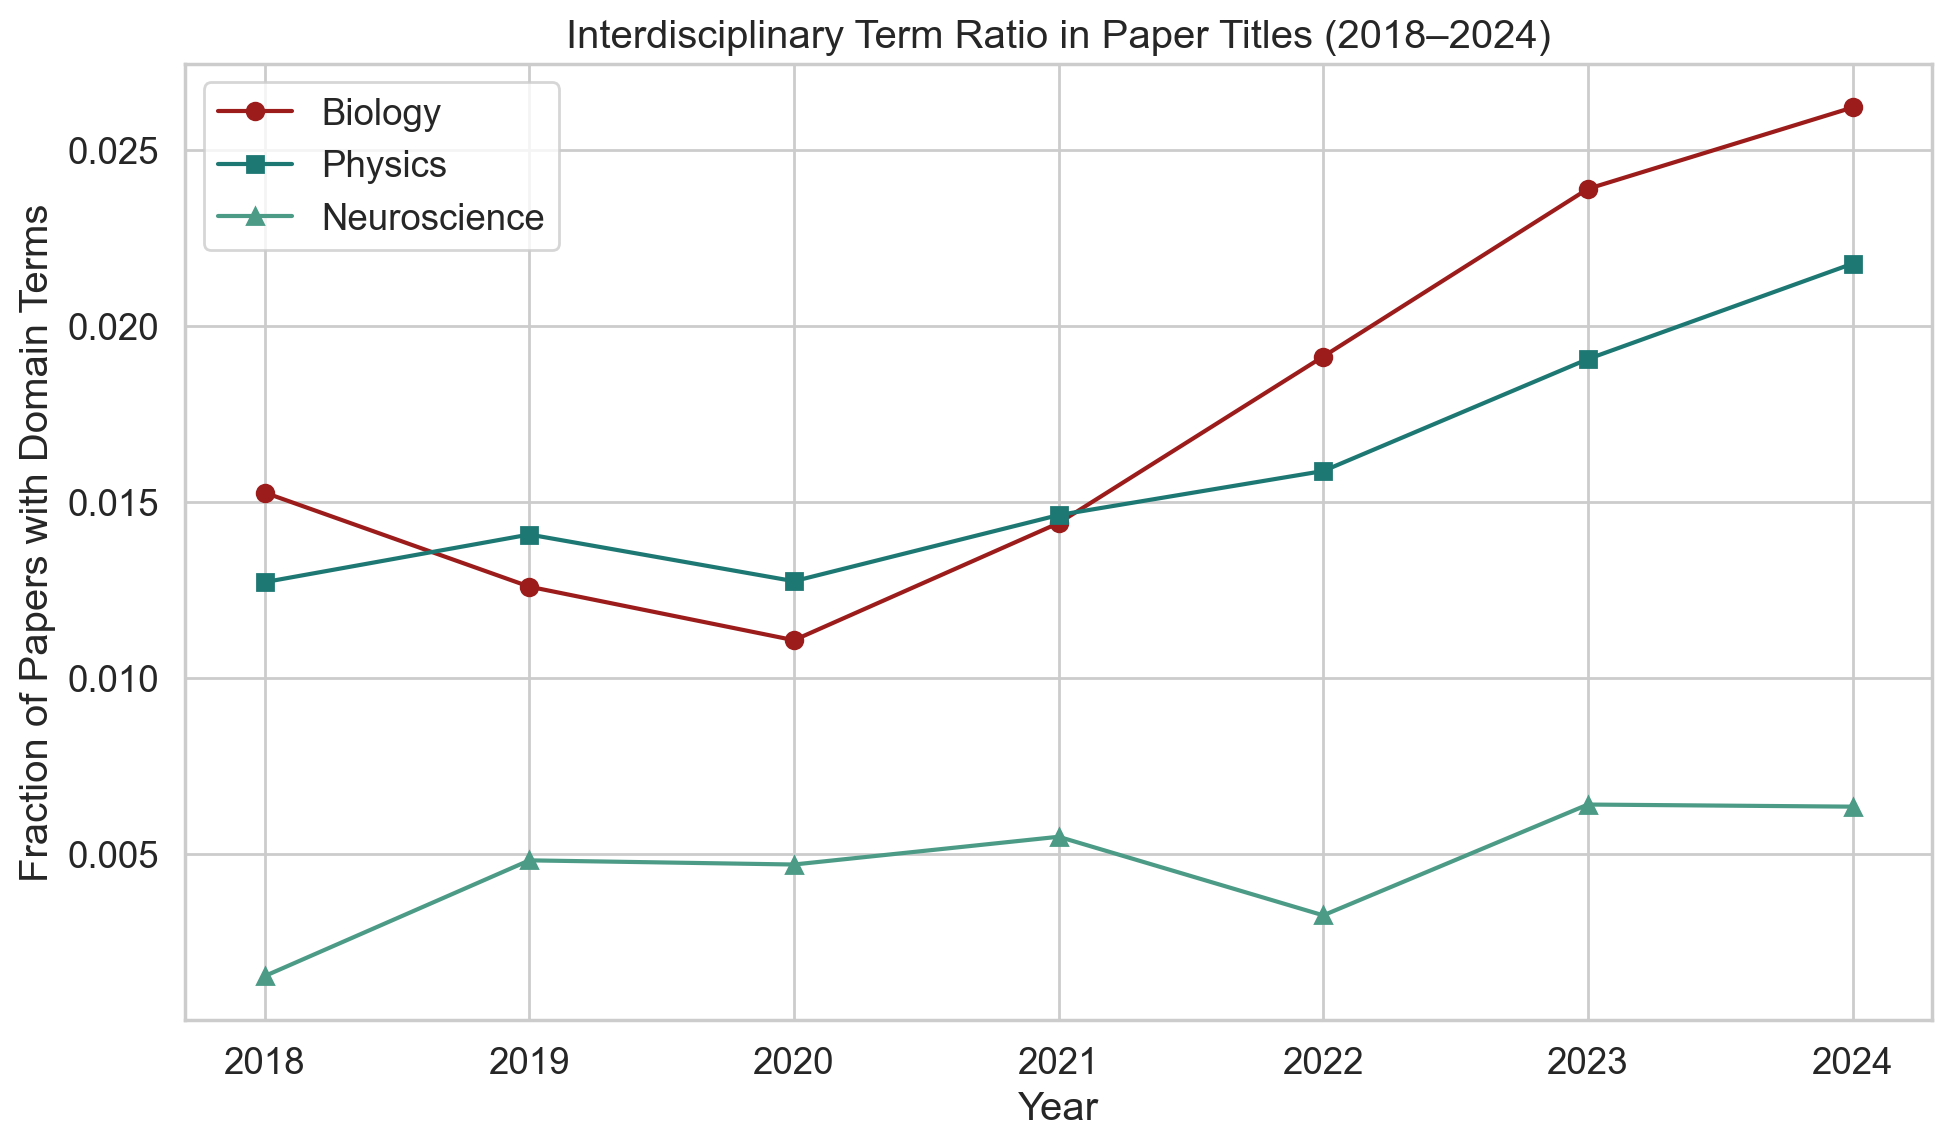

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

bio_color = "#9C1C1C"  
physics_color = "#1D7874"  
neuro_color = "#4C9B87"  

plt.figure(figsize=(10, 6))

plt.plot(interdisciplinary_df["Year"], interdisciplinary_df["bio_ratio"], label="Biology", marker='o', color=bio_color)
plt.plot(interdisciplinary_df["Year"], interdisciplinary_df["physics_ratio"], label="Physics", marker='s', color=physics_color)
plt.plot(interdisciplinary_df["Year"], interdisciplinary_df["neuro_ratio"], label="Neuroscience", marker='^', color=neuro_color)

plt.title("Interdisciplinary Term Ratio in Paper Titles (2018–2024)")
plt.xlabel("Year")
plt.ylabel("Fraction of Papers with Domain Terms")

plt.legend()

plt.tight_layout()
plt.show()

One reason why maybe neuroscience is lacking behind is because based on our current method of identifying domains, a lot of words are common to neuroscience and ml. Such as #"language","neuron", "attention", "memory", and others. We have excluded this and hence we are able to print this incomplete picture. 

In [ ]:
def contains_any_seed(title):
    tokens = tokenize_title(title)
    return bool(tokens & (bio_seeds | physics_seeds | neuro_seeds))

unique_titles = (
    icml_iclr_neurips[icml_iclr_neurips["Title"].apply(contains_any_seed)]
    ["Title"]
    .drop_duplicates()
    .reset_index(drop=True)
)

unique_titles.to_csv("titles_by_category/interdisciplinary_titles_only.csv", index=False, header=["Title"])

print(f"{len(unique_titles)} unique titles saved to interdisciplinary_titles_only.csv")

1426 unique titles saved to interdisciplinary_titles_only.csv
